# Markov Chain Monte Carlo (MCMC) Simulation on Stock Price Forecasting Using Python

In [27]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [28]:
import numpy as np
import pandas as pd

#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#from statsmodels.tsa.stattools import acf, pacf, q_stat, adfuller, grangercausalitytests
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [29]:
import platform
print(f"Python version: {platform.python_version()}")
print(f"numpy version: {np.__version__}")
print(f"panda version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
import statsmodels
print(f"statsmodel version: {statsmodels.__version__}")
import scipy
print(f"scipy version: {scipy.__version__}")

Python version: 3.10.14
numpy version: 1.26.4
panda version: 2.2.1
seaborn version: 0.13.2
matplotlib version: 3.7.5
statsmodel version: 0.14.1
scipy version: 1.14.1


## Helper Function

In [30]:
# Helper Function to fetch historical stock data
import yfinance as yf
def get_stock_data(ticker, start_date, end_date):
    try:
        # https://medium.com/nerd-for-tech/all-you-need-to-know-about-yfinance-yahoo-finance-library-fa4c6e48f08e
        #data = yf.Ticker(ticker).history(start=start_date, end=end_date)  
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        return f"Error fetching data: {e}"

## Step 1: Gather Historical Data

In [31]:
ticker_symbol = "PREIX"  #  T. Rowe Price Equity Index 500 Fund
start_date = "2000-01-01"
end_date = "2024-10-01"
stock_data = get_stock_data(ticker_symbol, start_date, end_date)
stock_data.asfreq('B').index  # set index frequency to business daliy
stock_data.info()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6225 entries, 2000-01-03 to 2024-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6225 non-null   float64
 1   High       6225 non-null   float64
 2   Low        6225 non-null   float64
 3   Close      6225 non-null   float64
 4   Adj Close  6225 non-null   float64
 5   Volume     6225 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 469.5 KB


In [32]:
stock_data.isnull().sum(axis=0) # check any NA

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [33]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-24,151.179993,151.179993,151.179993,151.179993,151.179993,0
2024-09-25,150.899994,150.899994,150.899994,150.899994,150.899994,0
2024-09-26,151.100006,151.100006,151.100006,151.100006,151.100006,0
2024-09-27,150.910004,150.910004,150.910004,150.910004,150.910004,0
2024-09-30,151.559998,151.559998,151.559998,151.559998,151.559998,0


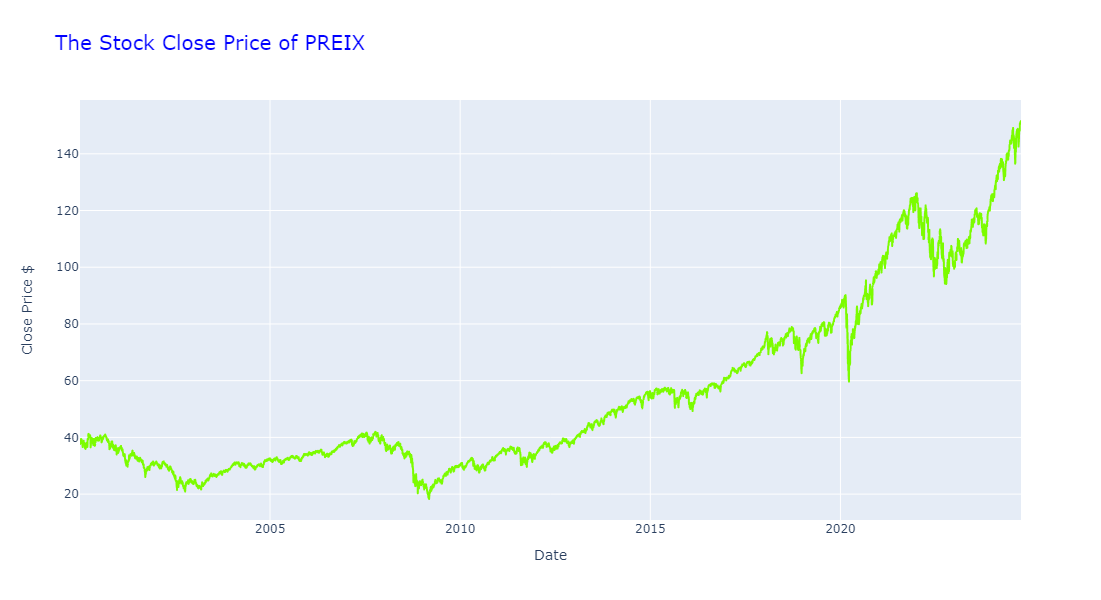

In [34]:
import plotly.express as px

fig = px.line(stock_data, x=stock_data.index, y='Close', title=f'The Stock Close Price of {ticker_symbol}',
              labels={'Close': 'Close Price $'},
              template='plotly', width=1000, height=600)
fig.update_traces(line_color='lawngreen')
fig.update_layout(title_font_color='blue', title_font_size=20)
fig.show()

## Features Engineering

In [35]:
# calculate the daily returns of the stock investment based on the percentage of the close price changes.
# The pct_change method will automatically calculate the percentage changes of the current day’s close price compared with the previous day. 
stock_data['Daily Return'] = stock_data['Close'].pct_change()
stock_data.dropna(inplace=True)

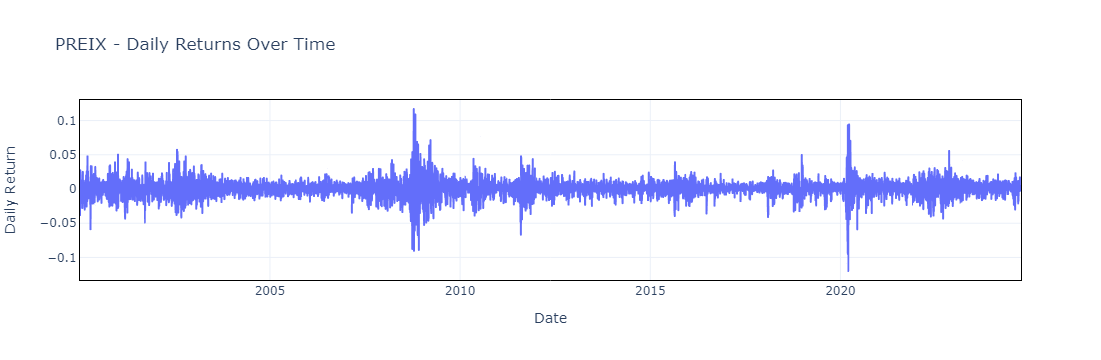

In [36]:
import plotly.express as px

fig = px.line(stock_data, x=stock_data.index, y='Daily Return', title=f'{ticker_symbol} - Daily Returns Over Time',
              labels={'DailyReturn': 'Daily Returns'},
              template='plotly_white')
fig.update_layout(showlegend=False)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.show()


In [37]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
count,6224.000000,6224.000000,6224.000000,6224.000000,6224.000000,6224.0,6224.000000
mean,55.380831,55.380831,55.380831,55.380831,47.675474,0.0,0.000293
std,31.148999,31.148999,31.148999,31.148999,33.309554,0.0,0.012265
min,18.280001,18.280001,18.280001,18.280001,13.669554,0.0,-0.119779
25%,32.307501,32.307501,32.307501,32.307501,23.077884,0.0,-0.004869
50%,39.825001,39.825001,39.825001,39.825001,29.803762,0.0,0.000605
75%,73.072500,73.072500,73.072500,73.072500,65.321676,0.0,0.005921
max,151.559998,151.559998,151.559998,151.559998,151.559998,0.0,0.116819


In [38]:
from scipy.stats import kstest, t, norm

# Fit the data using t-distribution
params = t.fit(stock_data['Daily Return'])
d, p_value = kstest(stock_data['Daily Return'], 't', args=params)
print(f"KS Statistic: {d}, P-Value: {p_value}")

if p_value > 0.05:
    print('Sample fits the t-distribution (fail to reject H0)')
else:
    print('Sample does not fit the t-distribution (reject H0)')

KS Statistic: 0.016994153994507558, P-Value: 0.05429605973725893
Sample fits the t-distribution (fail to reject H0)


Degrees of Freedom: 2.6606212055936953, Mean: 0.0006423654065788996, Standard Deviation: 0.007119559788511665


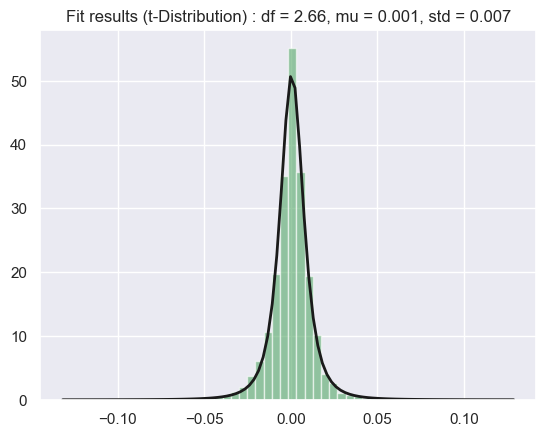

In [39]:
# Fit a t-distribution to the daily return data
params = t.fit(stock_data['Daily Return'])

# Get the parameters
dfree, mu, std = params
print(f"Degrees of Freedom: {dfree}, Mean: {mu}, Standard Deviation: {std}")

# Plot the histogram and the PDF
plt.hist(stock_data['Daily Return'], bins=50, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = t.pdf(x, dfree, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = f"Fit results (t-Distribution) : df = {dfree:.2f}, mu = {mu:.3f}, std = {std:.3f}"
plt.title(title)

plt.show()

# Save the figure
#plt.savefig('t_dist.jpg')

## Define the States of a Markov Chain
### we identified three distinct states that the price changes could exhibit on any given trading day:

    Up: This state is observed when today’s price surpasses that of the previous day. (Bull)
    Down: This state occurs when today’s price is lower than yesterday’s. (Bear)
    Stagnant: This is a state of price stability, where today’s price mirrors that of the previous day.

In [40]:
# Define thresholds 

mean_return = stock_data['Daily Return'].mean()
std_return = stock_data['Daily Return'].std()

# Define thresholds - one standard deviation
up_threshold = mean_return + std_return
down_threshold = mean_return - std_return

In [41]:
def classify_state(return_value, up_thresh, down_thresh):
    if return_value > up_thresh:
        return 'Up'
    elif return_value < down_thresh:
        return 'Down'
    else:
        return 'Stagnant'

stock_data['Markov State'] = stock_data['Daily Return'].apply(lambda x: classify_state(x, up_threshold, down_threshold))

In [42]:
# Shift 'Markov State' column to get previous state
stock_data['Prev State'] = stock_data['Markov State'].shift(1)

# Create a transition matrix
transition_counts = pd.crosstab(stock_data['Prev State'], stock_data['Markov State'])

# Normalize to get probabilities
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)
transition_matrix

Markov State,Down,Stagnant,Up
Prev State,,,
Down,0.160059,0.649046,0.190896
Stagnant,0.095132,0.821501,0.083367
Up,0.166667,0.717320,0.116013


In [43]:
transition_matrix.to_numpy()

array([[0.16 , 0.649, 0.191],
       [0.095, 0.822, 0.083],
       [0.167, 0.717, 0.116]])

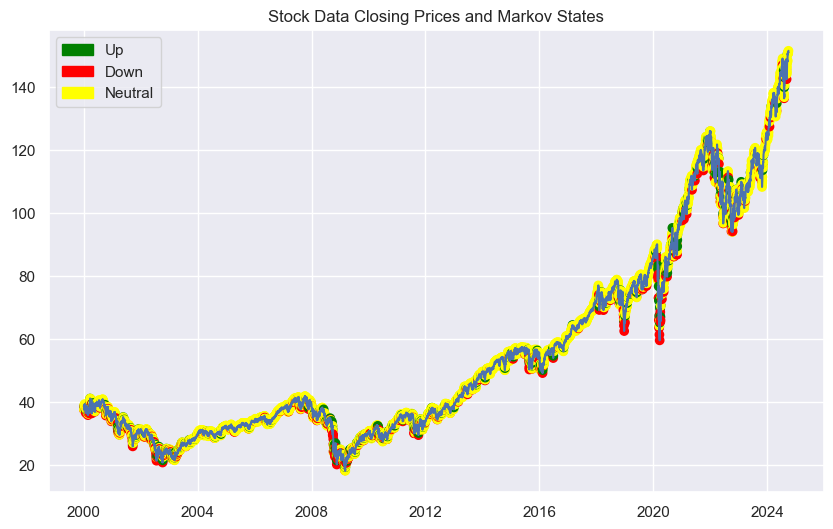

In [80]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'], label='Closing Price')
scatter = plt.scatter(stock_data.index, stock_data['Close'], c=stock_data['Markov State'].apply(lambda x: 'green' if x == 'Up' else 'red' if x == 'Down' else 'yellow'))

# Create custom legend
up_patch = mpatches.Patch(color='green', label='Up')
down_patch = mpatches.Patch(color='red', label='Down')
neutral_patch = mpatches.Patch(color='yellow', label='Neutral')
plt.legend(handles=[up_patch, down_patch, neutral_patch])

from importlib import reload
plt=reload(plt)
plt.title('Stock Data Closing Prices and Markov States')
plt.show()



### Markov Chain Diagram
#### library from https://naysan.ca/2022/12/29/drawing-state-transition-diagrams-in-python-improved-version/

### Basic Install
    Clone the https://github.com/NaysanSaran/markov-chain repository
    Copy the files src/node.py and src/markovchain.py in your script directory

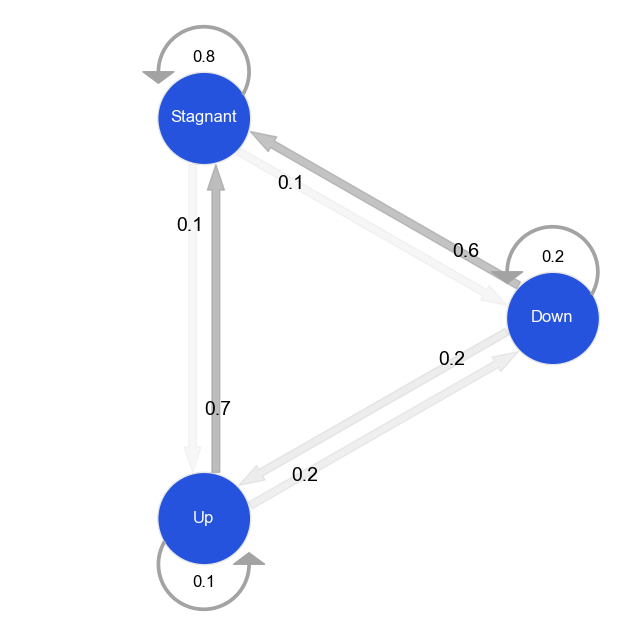

In [60]:
# import it as a module
from markovchain import MarkovChain

# Your states and transition matrix
states = ['Down', 'Stagnant', 'Up']

P = transition_matrix.to_numpy()

mc = MarkovChain(P, states)
mc.draw("markov-chain-three-states.png")

### What is the meaning of Equilibrium Matrix? 
#### The equilibrium Matrix is a stationary state.  No matter what state you start in, over time, you end up with the same probabilities (a stationary distribution).

In [61]:
import numpy as np

def find_equilibrium(transition_matrix):
    # Add a small number to ensure the matrix is not singular
    transition_matrix = transition_matrix + 1e-6
    # Initialize the equilibrium vector
    equilibrium = np.random.rand(transition_matrix.shape[0])
    # Normalize the equilibrium vector
    equilibrium = equilibrium / np.sum(equilibrium)
    # Iterate until convergence
    while True:
        new_equilibrium = np.dot(equilibrium, transition_matrix)
        # Check for convergence
        if np.allclose(equilibrium, new_equilibrium):
            break
        # Update the equilibrium vector
        equilibrium = new_equilibrium
    return equilibrium

# find equilibrium matrix

equilibrium = find_equilibrium(transition_matrix)
print(equilibrium)


[0.109 0.792 0.098]


Transition Matrix:
 Markov State      Down  Stagnant        Up
Prev State                                
Down          0.160059  0.649046  0.190896
Stagnant      0.095132  0.821501  0.083367
Up            0.166667  0.717320  0.116013


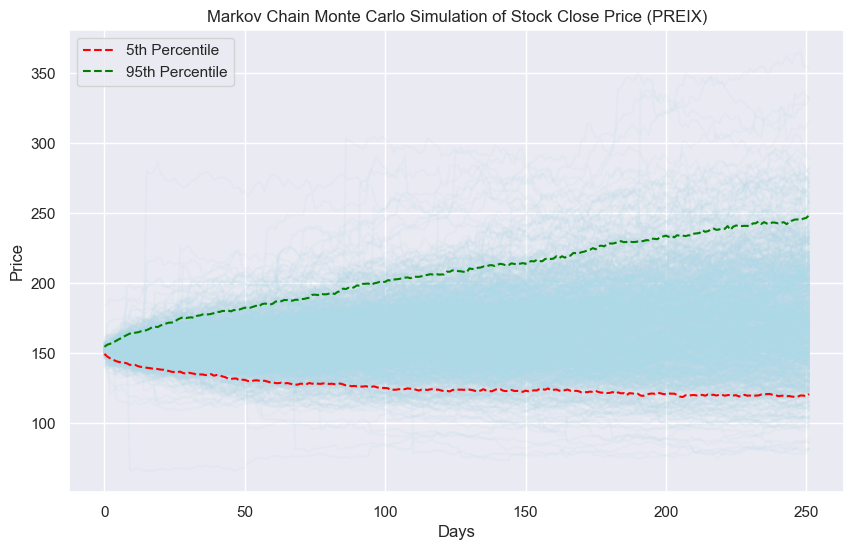

Value at Risk (VaR) at 95% confidence level: -96.86
95% Confidence Interval for the final price: (99.37445997352332, 255.0628840937619)


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, norm

# Fit the Student's t distribution to the returns data
params = t.fit(stock_data['Daily Return'].dropna())

# Get the parameters of the distribution
df_t, mu, sigma = params

# from above
# states = ['Down', 'Stagnant', 'Up']
print("Transition Matrix:\n", transition_matrix)
initial_price = stock_data['Close'].iloc[-1]  # Initial stock price

# 4. Monte Carlo Simulation based on Markov Chain
n_simulations = 1000  # Number of simulation paths
n_days = 252  # Simulate for 1 year (252 trading days)

# Initial state probabilities
initial_state = stock_data['Markov State'].iloc[-1]
initial_state_probabilities = [1 if state == initial_state else 0 for state in states]

# Simulating the paths
simulated_paths = []
for sim in range(n_simulations):
    simulated_returns = []
    current_state = np.random.choice(states, p=initial_state_probabilities)
    
    for day in range(n_days):
        # Simulate return based on the current state using Student's t-distribution
        if current_state == "Up":
            daily_return = t.rvs(df_t, loc=mu + sigma, scale=sigma)
        elif current_state == "Down":
            daily_return = t.rvs(df_t, loc=mu - sigma, scale=sigma)
        else:
            daily_return = t.rvs(df_t, loc=mu, scale=sigma)
        
        simulated_returns.append(daily_return)
        # Transition to the next state based on the transition matrix
        current_state = np.random.choice(states, p=transition_matrix.loc[current_state].values)
    
    # Cumulative price based on returns
    simulated_prices = initial_price * np.exp(np.cumsum(simulated_returns))
    simulated_paths.append(simulated_prices)

# Convert the list of paths to a DataFrame
simulated_paths_df = pd.DataFrame(simulated_paths).T

# 5. Plotting the Monte Carlo simulation
plt.figure(figsize=(10, 6))
plt.plot(simulated_paths_df, color="lightblue", alpha=0.1)

# Add 5% and 95% percentile lines
percentiles_5 = simulated_paths_df.quantile(0.05, axis=1)
percentiles_95 = simulated_paths_df.quantile(0.95, axis=1)

plt.plot(percentiles_5, color="red", linestyle="--", label="5th Percentile")
plt.plot(percentiles_95, color="green", linestyle="--", label="95th Percentile")

# Add labels and title
plt.title(f"Markov Chain Monte Carlo Simulation of Stock Close Price ({ticker_symbol})")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

# Save the figure
#plt.savefig('MCMC.jpg')

# 6. Computing VaR (Value at Risk)
final_prices = simulated_paths_df.iloc[-1]
losses = initial_price - final_prices
confidence_level = 0.95

# VaR at 95% confidence level
var_95 = np.percentile(losses, (1 - confidence_level) * 100)
print(f"Value at Risk (VaR) at 95% confidence level: {var_95:.2f}")

# 7. Computing Confidence Intervals
mean_final_price = np.mean(final_prices)
std_final_price = np.std(final_prices)
ci_95 = norm.interval(0.95, loc=mean_final_price, scale=std_final_price)

print(f"95% Confidence Interval for the final price: {ci_95}")


In [97]:
df = stock_data.copy()
df.drop(['Volume' , 'Markov State', 'Prev State' ], axis=1, inplace=True)

In [98]:
df.tail()

,Open,High,Low,Close,Adj Close,Daily Return
Date,,,,,,
2024-09-24,151.179993,151.179993,151.179993,151.179993,151.179993,0.002520
2024-09-25,150.899994,150.899994,150.899994,150.899994,150.899994,-0.001852
2024-09-26,151.100006,151.100006,151.100006,151.100006,151.100006,0.001325
2024-09-27,150.910004,150.910004,150.910004,150.910004,150.910004,-0.001257
2024-09-30,151.559998,151.559998,151.559998,151.559998,151.559998,0.004307


## Use Technical Indicator for calculating Markov Chain Matrix
### Relative Strength Index (RSI) - Momentum Indicator

Transition Matrix:
                 Up      Down  Stagnant
Up        0.766697  0.000000  0.233303
Down      0.000000  0.621693  0.378307
Stagnant  0.053872  0.030093  0.916035
Equilibrium Matrix:
 [0.176 0.061 0.763]
Value at Risk (VaR) at 95% confidence level: -181.95
95% Confidence Interval for the final price: (115.1430763152254, 343.6266584758358)


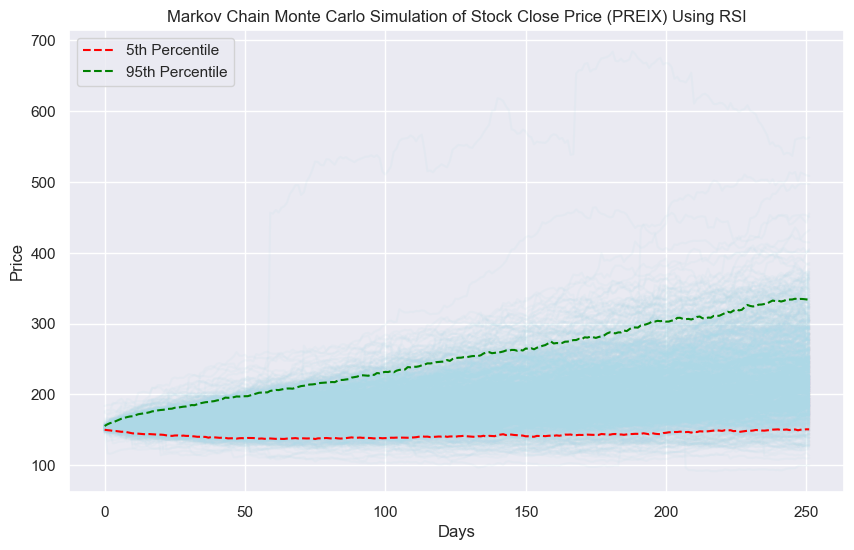

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, norm

# Fit the Student's t distribution to the returns data
params = t.fit(df['Daily Return'].dropna())

# Get the parameters of the distribution
df_t, mu, sigma = params


# Calculate the RSI Indicator
def calculate_rsi(data, window=14):
    delta = data["Close"].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(50)  # Filling NaN with 50 (neutral RSI)

# 1. Compute RSI
df["RSI"] = calculate_rsi(df)

# 2. Defining Markov States based on RSI values
rsi_upper = 70  # Overbought threshold for 'Up' state
rsi_lower = 30  # Oversold threshold for 'Down' state

def markov_state(rsi):
    if rsi > rsi_upper:
        return "Up"
    elif rsi < rsi_lower:
        return "Down"
    else:
        return "Stagnant"

df["State"] = df["RSI"].apply(markov_state)

# 3. Building the Transition Matrix
states = ["Up", "Down", "Stagnant"]
transition_matrix = pd.DataFrame(np.zeros((3, 3)), columns=states, index=states)


# Count state transitions based on the RSI states
for i in range(1, len(df)):
    prev_state = df.iloc[i-1]["State"]
    curr_state = df.iloc[i]["State"]
    transition_matrix.loc[prev_state, curr_state] += 1

# Normalize to get transition probabilities
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
print("Transition Matrix:\n", transition_matrix)

equilibrium = find_equilibrium(transition_matrix)
print("Equilibrium Matrix:\n", equilibrium)


# 4. Monte Carlo Simulation based on Markov Chain
n_simulations = 1000  # Number of simulation paths
n_days = 252  # Simulate for 1 year (252 trading days)
initial_price = df['Close'].iloc[-1]  # Initial stock price

# Initial state probabilities
initial_state = df["State"].iloc[-1]
initial_state_probabilities = [1 if state == initial_state else 0 for state in states]

# Simulating the paths
simulated_paths = []
for sim in range(n_simulations):
    simulated_returns = []
    current_state = np.random.choice(states, p=initial_state_probabilities)
    
    for day in range(n_days):
        # Simulate return based on the current state using Student's t-distribution
        if current_state == "Up":
            daily_return = t.rvs(df_t, loc=mu + sigma, scale=sigma)
        elif current_state == "Down":
            daily_return = t.rvs(df_t, loc=mu - sigma, scale=sigma)
        else:
            daily_return = t.rvs(df_t, loc=mu, scale=sigma)
        
        simulated_returns.append(daily_return)
        # Transition to the next state based on the transition matrix
        current_state = np.random.choice(states, p=transition_matrix.loc[current_state].values)
    
    # Cumulative price based on returns
    simulated_prices = initial_price * np.exp(np.cumsum(simulated_returns))
    simulated_paths.append(simulated_prices)

# Convert the list of paths to a DataFrame
simulated_paths_df = pd.DataFrame(simulated_paths).T

# 5. Plotting the Monte Carlo simulation
plt.figure(figsize=(10, 6))
plt.plot(simulated_paths_df, color="lightblue", alpha=0.1)

# Add 5% and 95% percentile lines
percentiles_5 = simulated_paths_df.quantile(0.05, axis=1)
percentiles_95 = simulated_paths_df.quantile(0.95, axis=1)

plt.plot(percentiles_5, color="red", linestyle="--", label="5th Percentile")
plt.plot(percentiles_95, color="green", linestyle="--", label="95th Percentile")

# Add labels and title
plt.title(f"Markov Chain Monte Carlo Simulation of Stock Close Price ({ticker_symbol}) Using RSI")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

# Save the figure
#plt.savefig('MCMC-RSI.jpg')

# 6. Computing VaR (Value at Risk)
final_prices = simulated_paths_df.iloc[-1]
losses = initial_price - final_prices
confidence_level = 0.95

# VaR at 95% confidence level
var_95 = np.percentile(losses, (1 - confidence_level) * 100)
print(f"Value at Risk (VaR) at 95% confidence level: {var_95:.2f}")

# 7. Computing Confidence Intervals
mean_final_price = np.mean(final_prices)
std_final_price = np.std(final_prices)
ci_95 = norm.interval(0.95, loc=mean_final_price, scale=std_final_price)

print(f"95% Confidence Interval for the final price: {ci_95}")


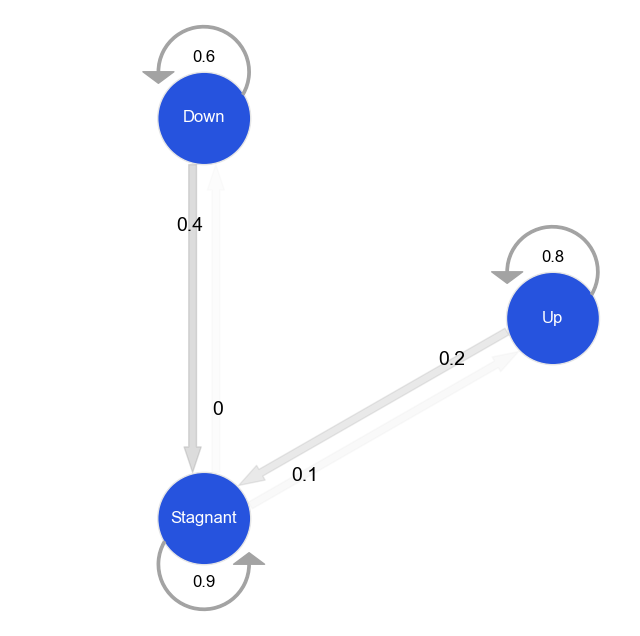

In [104]:
# import it as a module
from markovchain import MarkovChain

# Your states and transition matrix
states = ["Up", "Down", "Stagnant"]

P = transition_matrix.to_numpy()

mc = MarkovChain(P, states)
mc.draw("markov-chain-three-states2.png")